In [122]:
import torch
import torchvision
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import datetime

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setting

In [2]:
plt.style.use("dark_background")

# Model

In [265]:
class BiLSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, lstm_layer, dropout = 0.2, num_class = 8):
        super(BiLSTM, self).__init__()
        self.input_size = feature_size
        self.hidden_dim = hidden_size
        self.dropout = nn.Dropout(p = dropout)
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = hidden_size,
                            num_layers = lstm_layer,
                            dropout = dropout,
                            bidirectional = True)
        self.hidden2label = nn.Linear(hidden_size*2, num_class)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        label_space = self.hidden2label(lstm_out)
        label_scores = nn.Softmax(dim = 1)(label_space)

        return label_scores

In [357]:
sample = torch.rand([1, 1000, 32])
net = BiLSTM(feature_size = 32, hidden_size = 128, lstm_layer = 4)

In [358]:
pred = net(sample)
pred.shape

torch.Size([1, 1000, 8])

In [360]:
# t = list(pred.flatten().detach().numpy())
# plt.hist(t)

In [361]:
# predicted label example
(pred.squeeze().detach().numpy().argmax(axis = 1) + 1)[:100]

array([1, 5, 5, 1, 5, 8, 1, 2, 2, 7, 7, 5, 5, 5, 5, 7, 2, 8, 2, 4, 1, 1,
       3, 4, 8, 3, 8, 6, 2, 3, 7, 3, 8, 7, 4, 2, 1, 6, 1, 1, 5, 4, 6, 4,
       5, 6, 6, 6, 4, 7, 4, 4, 6, 7, 4, 2, 5, 2, 2, 3, 6, 4, 7, 7, 3, 7,
       3, 1, 7, 5, 2, 4, 8, 5, 4, 5, 8, 1, 2, 2, 5, 2, 8, 8, 7, 2, 6, 7,
       1, 1, 8, 6, 1, 4, 5, 7, 1, 8, 5, 1])

# Data

In [315]:
data_df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val_df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [318]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]
X_train, y_train = data_df.drop(col_drop_x + col_drop, axis = 1).fillna(0).copy(), data_df[col_label].copy()
X_train = X_train.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis = 0)
y_train -= 1

X_val, y_val = val_df.drop(col_drop_x + col_drop, axis = 1).fillna(0).copy(), val_df[col_label].copy()
X_val = X_val.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis = 0)
y_val -= 1

In [320]:
class TMR_Dataset(Dataset):
    def __init__(self, x_array, label):
        super().__init__()
        self.len, self.feature_size = x_array.shape
        self.data = x_array
        self.data = torch.tensor(self.data).float()
        self.label = label
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data[idx,:], self.label[idx])

In [343]:
BATCH_SIZE = 1024
EPOCHS = 10
LR = 0.001

In [344]:
data = TMR_Dataset(np.array(X_train), y_train)
train_loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = False)
X_val = torch.tensor(np.array(X_val), dtype = torch.float32)

In [345]:
# net = BiLSTM(feature_size = 32, hidden_size = 4, lstm_layer = 4)
# X, y = next(iter(train_loader))
# net(X.unsqueeze(0)).squeeze().argmax(dim = 1)

In [346]:
writer = SummaryWriter(log_dir = 'log', comment = "")

In [347]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BiLSTM(feature_size = 32, hidden_size = 128, lstm_layer = 4, dropout = 0.75, num_class = 8).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = LR, weight_decay = 0.95)
criterion = nn.CrossEntropyLoss()

In [352]:
net(X_val.unsqueeze(0)).squeeze()

tensor([6, 6, 6,  ..., 6, 6, 6])

In [348]:
global_step = 0
for epoch in range(EPOCHS):
    for i, (X, y) in enumerate(train_loader):
        output = net(X.unsqueeze(0)).squeeze()
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1

        if i % 100 == 0:
            net.eval()
            test_pred = net(X_val.unsqueeze(0)).squeeze().argmax(dim = 1)
            accuracy_train = accuracy_score(y, output.argmax(dim = 1))
            accuracy_val = accuracy_score(y_val, test_pred)
            print('epoch:{:<2d} | iteration:{:<4d} | loss:{:<6.4f} | accuracy_val:{:<4.2f} | accuracy_train:{:<4.2f}'.format(epoch, i, loss, accuracy_val, accuracy_train))

            # summary writer
            writer.add_scalar('loss_train', loss, global_step)
            writer.add_scalar('accuracy/train', accuracy_train, global_step)
            writer.add_scalar('accuracy/val', accuracy_val, global_step)
            writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], global_step)
            net.train()

epoch:0  | iteration:0    | loss:2.0795 | accuracy_val:0.16 | accuracy_train:0.13
epoch:0  | iteration:100  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.14
epoch:0  | iteration:200  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:0  | iteration:300  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:0  | iteration:400  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:0  | iteration:500  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:0  | iteration:600  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:0  | iteration:700  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.11
epoch:0  | iteration:800  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:0  | iteration:900  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:1  | iteration:0    | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:1  | iteration:100  | loss:2.0795 | accuracy_val:0.15 | accuracy_train:0.00
epoch:1  | itera

KeyboardInterrupt: 

# Test (Tiny DataSet)

In [252]:
global_step

38310

In [234]:
# data = TMR_Dataset(np.array(X_train)[:20,:], y_train[:20] - 1)
data = TMR_Dataset(np.array(X_train)[:20,:], [1]*10 + [0]*10)
train_loader = DataLoader(data, batch_size = 20, shuffle = False)

In [235]:
X, y = next(iter(train_loader))

In [236]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BiLSTM(feature_size = 32, hidden_size = 64, lstm_layer = 4).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()

In [237]:
global_step = 0
accs = []
for epoch in range(1000):
    output = net(X.unsqueeze(0)).squeeze()
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pred = output.argmax(dim = 1)
    accuracy = accuracy_score(y, pred)
    # print(epoch, accuracy)
    accs.append(accuracy)

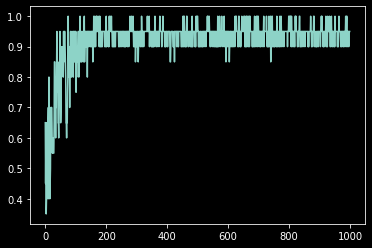

In [238]:
plt.plot(accs)